[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pranavm19/SBI-Tutorial/blob/main/notebooks/02_NFlows.ipynb)

In [1]:
# !python -m pip install sbi corner

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [18]:
# Recall the two moons model
def two_moons_sbi(theta, sigma=0.01):
    """Generate a two moons posterior"""
    n_samples = theta.shape[0]
    alpha = np.random.uniform(-np.pi/2, np.pi/2, n_samples)
    r = sigma * np.random.randn(n_samples) + 1
    x_1 = r * np.cos(alpha) + 1 - np.abs(theta[:, 0] + theta[:, 1])/np.sqrt(2)
    x_2 = r * np.sin(alpha) + (- theta[:, 0] + theta[:, 1])/np.sqrt(2)

    x =  np.stack([x_1, x_2], axis=-1)

    return x

Outline

1. What are normalizing flow, and how do they work (math + intuition building)
2. The I/O of normalizing flows - what do we want them to do?
2. Build an affine coupling layer
3. Normalizing flows using affine coupling layers and permutation masks
4. Performing inference

Vanilla conditional normalizing flows : we care about generating novel (x, y) points given context.  
Neural Posterior Estimation : we care about inferring context given novel (x, y) points. Basically, we flip the data and context over from the vanilla flow!

### **What are normalizing flows?**

#### Inference and density estimation


#### Change of variables formula


#### Transforming a data distribution to a base density



In [ ]:
# Base density, transform, and data distribution

In [ ]:
# Make figure 16.2 from the udl book

#### The API

Cool, so we have seen how a bijective transform can be used to "normalize" a given density. Let's make them a bit more powerful 💪

There are two components to a normalizing flow : the bijective transform (or a set of them), and the prior distribution. Once we have these, at train time, we can compute z given a batch of (x, context), and evaluate the loss. At test time, we can draw a sample from (z, context), and generate samples from the learned data distribution x (and evaluate the probability density!!). To do this, we will need:

`NF = NormalizingFlow(flows, prior)`
- `NF.forward(x, context) -> z, ldj`, 
- `NF.sample(z, context) -> x, ldj`

The `flows` object is usually a list of layers each of which is a bijective transform:

`T = AffineCouplingTransform()`
- `T.forward(x, context) -> z, ldj`
- `T.inverse(z, context) -> x, ldj`

### **Real NVP - Affine Coupling Flows**

The base density is quite clear, but how do we design the bijector? Especially one that is non-linear?

Real NVP - scale and shift networks

Cool, but how the hell is this non-linear and invertible? We're just scaling a shifting (so linear) and then half of the dimensions are being non-linearly transformed, so not invertible?!



In [3]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, context_dim):
        super().__init__()
        self.input_dim = input_dim
        self.context_dim = context_dim
        self.split_idx = input_dim - (input_dim // 2) # first part gets more dims if input_dim is odd

        # Define scale and shift networks
        self.scale_net = nn.Sequential(
            nn.Linear(self.split_idx + context_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 64), 
            nn.LeakyReLU(),
            nn.Linear(64, input_dim - self.split_idx)
        )
        self.shift_net = nn.Sequential(
            nn.Linear(self.split_idx + context_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 64), 
            nn.LeakyReLU(),
            nn.Linear(64, input_dim - self.split_idx)
        )

    def forward(self, x, context):
        # Split input tensor along the last dimension
        x_identity = x[..., :self.split_idx]
        x_transform = x[..., self.split_idx:]

        # Concatenate identity and context for both networks
        identity_context = torch.cat((x_identity, context), dim=-1)
        scale = self.scale_net(identity_context)
        shift = self.shift_net(identity_context)

        # Affine transformation on x_transform
        z_transform = x_transform * torch.exp(scale) + shift

        # Concatenate unchanged part with transformed part
        z = torch.cat((x_identity, z_transform), dim=-1)
        # Compute log-determinant of the Jacobian (sum of scale)
        ldj = torch.sum(scale, dim=-1)
        return z, ldj
    
    def inverse(self, z, context):
        # Inverse transform: split z into identity and transformed parts
        z_identity = z[..., :self.split_idx]
        z_transform = z[..., self.split_idx:]
        identity_context = torch.cat((z_identity, context), dim=-1)
        scale = self.scale_net(identity_context)
        shift = self.shift_net(identity_context)
        # Inverse affine transformation
        x_transform = (z_transform - shift) * torch.exp(-scale)
        x = torch.cat((z_identity, x_transform), dim=-1)
        ldj = -torch.sum(scale, dim=-1)
        return x, ldj


In [4]:
class NormalizingFlow(nn.Module):
    """
    A normalizing flow model composed of a sequence of affine coupling layers and a prior distribution.
    """
    def __init__(self, flows, prior=None):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.dim = self.flows[0].input_dim
        # Initialize the prior distribution (device will be set correctly later)
        if prior is None:
            self.prior = torch.distributions.MultivariateNormal(
                torch.zeros(self.dim), torch.eye(self.dim))
        else:
            self.prior = prior

        self.train_loss = []

    def forward(self, x, context):
        """
        Applies a sequence of flow transformations and accumulates the log-determinants.
        """
        ldj = torch.zeros(x.shape[0], device=x.device)
        for flow in self.flows:
            x, ldj_ = flow(x, context)
            ldj += ldj_
        return x, ldj

    def inverse(self, z, context):
        """
        Inverts the flow transformation from latent space back to the input space.
        """
        ldj = torch.zeros(z.shape[0], device=z.device)
        for flow in reversed(self.flows):
            z, ldj_ = flow.inverse(z, context)
            ldj += ldj_  # log-determinants are already negated in inverse
        return z, ldj

    @torch.no_grad()
    def sample(self, num_samples, context):
        """
        Generate samples from the model given a context.
        """
        device = next(self.parameters()).device
        z = self.prior.sample((num_samples,)).to(device)
        x, _ = self.inverse(z, context)
        return x

    def log_prob(self, x, context): 
        """
        Compute the log probability of x under the flow model.
        """
        z, ldj = self(x, context)
        log_pz = self.prior.log_prob(z)
        return log_pz + ldj


In [5]:
class PermutationLayer(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Create a random permutation for the feature indices.
        perm = torch.randperm(num_features)
        self.register_buffer("perm", perm)
        self.register_buffer("inv_perm", torch.argsort(perm))
    
    def forward(self, x, context):
        # Permuting the features; no effect on the log-determinant.
        x_permuted = x[..., self.perm]
        # Log-determinant is zero for a permutation
        log_det = torch.zeros(x.size(0), device=x.device)
        return x_permuted, log_det
    
    def inverse(self, x, context):
        # Inverse permutation
        x_inv = x[..., self.inv_perm]
        log_det = torch.zeros(x.size(0), device=x.device)
        return x_inv, log_det


In [45]:
# Handle dimensions
input_dim = 2
context_dim = 2
n_layers = 4
flows = []

# Define the model and optimizer
for i in range(n_layers):
    flows.append(AffineCouplingLayer(input_dim, context_dim))
    flows.append(PermutationLayer(input_dim))

model = NormalizingFlow(flows)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

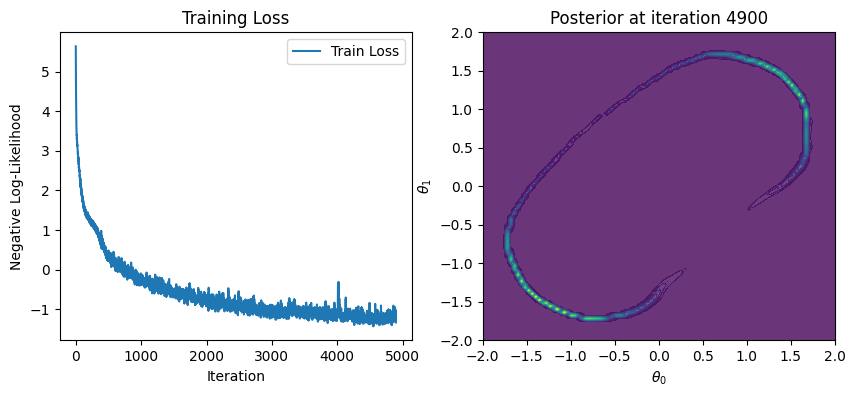

In [47]:
# Fix an observed data point x_obs
x_obs = torch.tensor([[0.0, 0.0]], dtype=torch.float32)

# Create a grid of theta-values over which to evaluate the posterior
n_samples = 100
theta0_vals = torch.linspace(-2, 2, n_samples)
theta1_vals = torch.linspace(-2, 2, n_samples)
TH0, TH1 = torch.meshgrid(theta0_vals, theta1_vals, indexing='xy')
theta_grid = torch.cat([TH0.reshape(-1,1), TH1.reshape(-1,1)], dim=1)

# Training settings
num_iter = 5000
num_update_iter = 100
batch_size = 256
losses = []

# Prepare figure
fig, (ax_loss, ax_posterior) = plt.subplots(1, 2, figsize=(10, 4))
plt.ion()

for i in range(num_iter):
    # Generate data
    theta = np.random.uniform(-4, 4, size=(batch_size, 2))
    x = two_moons_sbi(theta)
    x = torch.tensor(x, dtype=torch.float32)
    theta = torch.tensor(theta, dtype=torch.float32)

    # Standard training step
    optimizer.zero_grad()
    loss = -model.log_prob(x, theta).mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Update plots interactively
    if i % num_update_iter == 0:
        ax_loss.cla()
        ax_posterior.cla()

        # Training loss 
        ax_loss.plot(losses, label='Train Loss')
        ax_loss.set_title('Training Loss')
        ax_loss.set_xlabel('Iteration')
        ax_loss.set_ylabel('Negative Log-Likelihood')
        ax_loss.legend()

        # Approximate posterior 
        with torch.no_grad():
            # Replicate x_obs for every point in theta_grid so the shape matches
            x_obs_tiled = x_obs.repeat(theta_grid.shape[0], 1)

            # Posterior ~ exp(log p(x_obs | theta))
            post_vals = model.log_prob(x_obs_tiled, theta_grid).exp()
            post_2d = post_vals.view(n_samples, n_samples)

        # Contour-plot the posterior in theta-space
        c = ax_posterior.contourf(
            TH0.numpy(), TH1.numpy(), post_2d.numpy(),
            levels=50, alpha=0.8
        )
        ax_posterior.set_title(f'Posterior at iteration {i}')
        ax_posterior.set_xlabel(r'$\theta_0$')
        ax_posterior.set_ylabel(r'$\theta_1$')
        
        # Optionally add a colorbar if you like
        # fig.colorbar(c, ax=ax_posterior)

        clear_output(wait=True)
        display(fig)

plt.ioff();

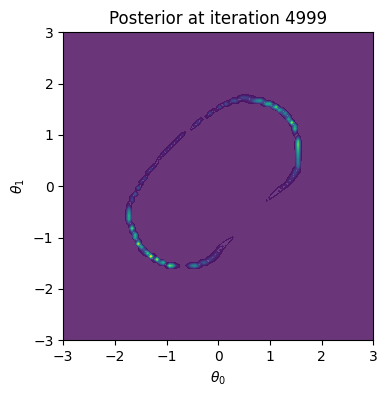

In [50]:
# The really cool thing is that we don't need to re-run the algorithm
# to infer posterior for a new data point! (more or less...)
x_obs = torch.tensor([[0.1, 0.1]], dtype=torch.float32)

# Create a grid of theta-values over which to evaluate the posterior
n_samples = 100
theta0_vals = torch.linspace(-3, 3, n_samples)
theta1_vals = torch.linspace(-3, 3, n_samples)
TH0, TH1 = torch.meshgrid(theta0_vals, theta1_vals, indexing='xy')
theta_grid = torch.cat([TH0.reshape(-1,1), TH1.reshape(-1,1)], dim=1)

fig, ax = plt.subplots(1, 1, figsize=[4, 4])

with torch.no_grad():
    # Replicate x_obs for every point in theta_grid so the shape matches
    x_obs_tiled = x_obs.repeat(theta_grid.shape[0], 1)

    # Posterior ~ exp(log p(x_obs | theta))
    post_vals = model.log_prob(x_obs_tiled, theta_grid).exp()
    post_2d = post_vals.view(n_samples, n_samples)

# Contour-plot the posterior in theta-space
c = ax.contourf(
    TH0.numpy(), TH1.numpy(), post_2d.numpy(),
    levels=50, alpha=0.8
)
ax.set_title(f'Posterior at iteration {i}')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')

plt.show()

In [26]:
# Plot posterior using corner

tensor([[1., 0.]])

### **Repeat using `sbi` toolbox**



In [ ]:
# Use sbi for the same analysis

### **Posterior checks**

### **Outro**

#### Additional reading
